# Проект по МО. Распознавание интонации

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import random

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

import seaborn as sns

%matplotlib inline

## Загрузка и обработка данных

In [42]:
df = pd.read_csv('pitch_data_new.csv')

In [43]:
df.head()

,Maximum pitch (Hz),Minimum pitch (Hz),Duration,Pitch mean,PmaxTime,PminTime,fmaxPosRat,fminPosRat,Frng,MC
0,276.338989,143.104278,0.989799,209.721634,0.624677,0.378977,0.631115,0.382883,0.517858,MC1
1,282.786034,118.811589,0.592112,200.798812,0.117609,0.098287,0.198627,0.165994,0.420147,MC1
2,272.196684,190.064014,0.512574,231.130349,0.144792,0.312404,0.282480,0.609479,0.698260,MC1
3,314.067647,133.936885,0.901424,224.002266,0.445318,0.425851,0.494016,0.472421,0.426459,MC1
4,293.965389,202.893507,0.477224,248.429448,0.137941,0.315122,0.289049,0.660321,0.690195,MC1


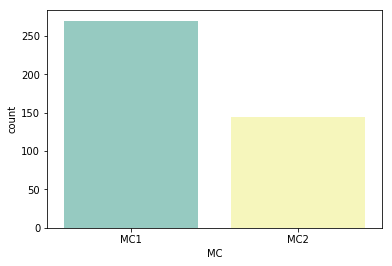

In [44]:
sns.countplot(x=df['MC'], data=df, palette="Set3") 
# MC1 - невопросительный, MC2 - вопросительный

In [75]:
len(df)

414

In [45]:
df.groupby('MC').describe()

Duration                                                              \
       count      mean       std       min       25%       50%       75%   
MC                                                                         
MC1    270.0  0.862611  0.405648  0.204104  0.561287  0.788148  1.078213   
MC2    144.0  1.074886  0.428961  0.357712  0.804206  1.006693  1.285650   

                Frng           ...  fmaxPosRat           fminPosRat            \
          max  count      mean ...         75%       max      count      mean   
MC                             ...                                              
MC1  2.306585  270.0  0.576900 ...    0.446833  0.990816      270.0  0.665397   
MC2  2.670153  144.0  0.496366 ...    0.645529  0.985641      144.0  0.609456   

                                                            
          std       min       25%       50%       75%  max  
MC                                                          
MC1  0.288445  0.000000  0.464742  0.766587  0.896184  1.0  
MC2  0.314777  0.018881  0.321288  0.688305  0.904900  1.0  

[2 rows x 72 columns]

In [78]:
df.iloc[0:len(df), 0:9]

Maximum pitch (Hz)
Minimum pitch (Hz)
Duration
Pitch mean
PmaxTime
PminTime
fmaxPosRat
fminPosRat
Frng


In [82]:
def merge_vectores(row):
    arr = [i for i in row]
    return arr

# итерируем строки датафрейма и склеиваем содержание нужных столбцов, запиываем результат в новый стоблец
df['features'] = [merge_vectores(df.iloc[row, 0:9]) for row in df.index]

### Балансируем выборки

In [84]:
mc1 = df[df['MC']=='MC1'] # невопросительные мелодические контуры

In [85]:
mc2 = df[df['MC']=='MC2'] # вопросительные мелодические контуры

In [86]:
mc1 = mc1[:len(mc2)]

In [87]:
frames = [mc1, mc2]
df_new = pd.concat(frames)

In [88]:
df_new = df_new.sample(frac=1) # перемешали данные

In [89]:
len(df_new)

288

### разделим датафрейм на тренировочную и тестовую выборки

In [90]:
perc = int(len(df_new) * 0.8)
train = df_new[:perc]
test = df_new[perc:]

In [91]:
print(len(train), len(test))

230 58


## Деревья решений

In [93]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [103]:
x_train = [i for i in train.features]
x_test = [i for i in test.features]

In [102]:
ppl = Pipeline(
    [('tree', DecisionTreeClassifier(random_state=42))]
)
ppl.fit(x_train, y=train.MC)

Pipeline(memory=None,
     steps=[('tree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'))])

In [104]:
print(classification_report(test.MC, ppl.predict(x_test)))
print(accuracy_score(test.MC, ppl.predict(x_test)))

             precision    recall  f1-score   support

        MC1       0.60      0.69      0.64        26
        MC2       0.71      0.62      0.67        32

avg / total       0.66      0.66      0.66        58

0.655172413793


дефолтный вариант работает не так уж и плохо..

Попробуем теперь какую-нибудь другую модель, например, логистическую регрессию.

## Логистическая регрессия

In [114]:
from sklearn.linear_model import LogisticRegression

In [107]:
ppl = Pipeline(
    [('tree', LogisticRegression(random_state=42))]
)
ppl.fit(x_train, y=train.MC)

print(classification_report(test.MC, ppl.predict(x_test)))
print(accuracy_score(test.MC, ppl.predict(x_test)))

             precision    recall  f1-score   support

        MC1       0.64      0.62      0.63        26
        MC2       0.70      0.72      0.71        32

avg / total       0.67      0.67      0.67        58

0.672413793103


## Random forest

In [183]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [195]:
ppl = Pipeline(
    [('tree',  RandomForestClassifier(max_depth=5, n_estimators=10, max_features=7))]
)
ppl.fit(x_train, y=train.MC)

print(classification_report(test.MC, ppl.predict(x_test)))
print(accuracy_score(test.MC, ppl.predict(x_test)))

             precision    recall  f1-score   support

        MC1       0.79      0.73      0.76        26
        MC2       0.79      0.84      0.82        32

avg / total       0.79      0.79      0.79        58

0.793103448276


если покрутить max_features, можно получить лучший результат.

In [196]:
from sklearn.metrics import confusion_matrix

In [197]:
y_pred = ppl.fit(x_train, train.MC).predict(x_test)

In [198]:
print(len(y_pred), len(test.MC))

58 58


In [199]:
confusion_matrix(test.MC, y_pred)

array([[19,  7],
       [ 8, 24]])

## AdaBoostClassifier

In [135]:
ppl = Pipeline(
    [('tree',  AdaBoostClassifier())]
)
ppl.fit(x_train, y=train.MC)

print(classification_report(test.MC, ppl.predict(x_test)))
print(accuracy_score(test.MC, ppl.predict(x_test)))

             precision    recall  f1-score   support

        MC1       0.64      0.62      0.63        26
        MC2       0.70      0.72      0.71        32

avg / total       0.67      0.67      0.67        58

0.672413793103


## K ближайших соседей

In [136]:
from sklearn.neighbors import KNeighborsClassifier

In [152]:
ppl = Pipeline(
    [('tree',  KNeighborsClassifier(4))]
)
ppl.fit(x_train, y=train.MC)

print(classification_report(test.MC, ppl.predict(x_test)))
print(accuracy_score(test.MC, ppl.predict(x_test)))

             precision    recall  f1-score   support

        MC1       0.62      0.88      0.73        26
        MC2       0.86      0.56      0.68        32

avg / total       0.75      0.71      0.70        58

0.706896551724


## SVC

In [153]:
from sklearn.svm import SVC

In [154]:
ppl = Pipeline(
    [('tree', SVC(kernel="linear", C=0.025))]
)
ppl.fit(x_train, y=train.MC)

print(classification_report(test.MC, ppl.predict(x_test)))
print(accuracy_score(test.MC, ppl.predict(x_test)))

             precision    recall  f1-score   support

        MC1       0.59      0.65      0.62        26
        MC2       0.69      0.62      0.66        32

avg / total       0.64      0.64      0.64        58

0.637931034483


In [161]:
ppl = Pipeline(
    [('tree', SVC(gamma=2, C=1))]
)
ppl.fit(x_train, y=train.MC)

print(classification_report(test.MC, ppl.predict(x_test)))
print(accuracy_score(test.MC, ppl.predict(x_test)))

             precision    recall  f1-score   support

        MC1       0.48      0.96      0.64        26
        MC2       0.83      0.16      0.26        32

avg / total       0.68      0.52      0.43        58

0.51724137931


## GaussianProcessClassifier

In [165]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [166]:
ppl = Pipeline(
    [('tree', GaussianProcessClassifier(1.0 * RBF(1.0)))]
)
ppl.fit(x_train, y=train.MC)

print(classification_report(test.MC, ppl.predict(x_test)))
print(accuracy_score(test.MC, ppl.predict(x_test)))

             precision    recall  f1-score   support

        MC1       0.59      0.77      0.67        26
        MC2       0.75      0.56      0.64        32

avg / total       0.68      0.66      0.65        58

0.655172413793


## Наивный Байес

In [167]:
from sklearn.naive_bayes import GaussianNB

In [168]:
ppl = Pipeline(
    [('tree', GaussianNB())]
)
ppl.fit(x_train, y=train.MC)

print(classification_report(test.MC, ppl.predict(x_test)))
print(accuracy_score(test.MC, ppl.predict(x_test)))

             precision    recall  f1-score   support

        MC1       0.59      0.65      0.62        26
        MC2       0.69      0.62      0.66        32

avg / total       0.64      0.64      0.64        58

0.637931034483


## QuadraticDiscriminantAnalysis

In [169]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [171]:
ppl = Pipeline(
    [('tree', QuadraticDiscriminantAnalysis())]
)
ppl.fit(x_train, y=train.MC)

print(classification_report(test.MC, ppl.predict(x_test)))
print(accuracy_score(test.MC, ppl.predict(x_test)))

             precision    recall  f1-score   support

        MC1       0.73      0.62      0.67        26
        MC2       0.72      0.81      0.76        32

avg / total       0.72      0.72      0.72        58

0.724137931034


/usr/local/lib/python3.5/dist-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


## MLPClassifier

In [173]:
from sklearn.neural_network import MLPClassifier

In [174]:
ppl = Pipeline(
    [('tree', MLPClassifier(alpha=1))]
)
ppl.fit(x_train, y=train.MC)

print(classification_report(test.MC, ppl.predict(x_test)))
print(accuracy_score(test.MC, ppl.predict(x_test)))

             precision    recall  f1-score   support

        MC1       0.73      0.42      0.54        26
        MC2       0.65      0.88      0.75        32

avg / total       0.69      0.67      0.65        58

0.672413793103
